# コードのテスト
## get_train_valid_test.py の関数について
- train/validation/testデータ管理クラス
- Tox21の画像のパス(train_files,validation_files,test_files)とラベル(y_train,y_valid,y_test)からtrain/validation/test の ImageDataGenerator まで作成する

In [1]:
import os
gpu_num = "0"
os.environ["CUDA_VISIBLE_DEVICES"] = str(gpu_num)

# モジュールimport
import os, sys
current_dir = os.path.dirname(os.path.abspath("__file__"))
path = os.path.join(current_dir, '../../')
sys.path.append(path)
from dataset import plot_log, prepare_data, util
from transformer import get_train_valid_test
from model import define_model, multi_loss, my_callback, my_metric
from predicter import roc_curve, conf_matrix, multi_predict, grad_cam

import numpy as np
import keras
import keras.backend as K
import matplotlib.pyplot as plt

sys.path.append(r'/home/tmp10014/jupyterhub/notebook/other/lib_DL/mixup-generator')
from random_eraser import get_random_eraser

plot_log.py: loaded as module file
prepare_data.py: loaded as module file
util.py: loaded as module file


Using TensorFlow backend.
/home/tmp10014/.conda/envs/py36/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: compiletime version 3.5 of module 'tensorflow.python.framework.fast_tensor_util' does not match runtime version 3.6
  return f(*args, **kwds)


get_train_valid_test.py: loaded as module file
define_model.py: loaded as module file
multi_loss.py: loaded as module file
my_callback.py: loaded as module file
my_metric.py: loaded as module file
roc_curve.py: loaded as module file
conf_matrix.py: loaded as module file
multi_predict.py: loaded as module file
grad_cam.py: loaded as module file


In [2]:
# ラベル情報などが書いたcsvファイル（tox21_compoundData.csv）
csv_path = r'../../storage/tox21_compoundData.csv'
# IDにファイルのフルパスつける
img_dir = r'../../storage/img/Wash/331x331/'
# 画像ファイルのサフィックス
img_suffix = r'_000.jpg'
# 欠損値を-1に置換したtox21_compoundData.csvのデータフレーム
df = prepare_data.make_label_df(csv_path, img_dir, img_suffix=img_suffix)
# Tox21の画像のパスとラベル(y_train,y_valid,y_test)を取得する
train_files, validation_files, test_files, y_train, y_valid, y_test = prepare_data.make_train_val_test(df)

training_set_y.shape: (11764, 12)
validation_set_y.shape: (296, 12)
test_set_y.shape: (647, 12)


## get_train_valid_test.LabeledDataset

In [3]:
%%time
train_batch_size=17
valid_batch_size=6
shape=[331, 331, 3]
num_classes=12
horizontal_flip=True
vertical_flip=True
rotation_range=60
zoom_range=[0.5, 1.9]
shear_range=0.2

d_cls = get_train_valid_test.LabeledDataset(shape, train_batch_size, valid_batch_size)
d_cls.load_train_as_image(train_files, y_train)
d_cls.load_validation_as_image(validation_files, y_valid)
d_cls.load_test_as_image(test_files, y_test)

# ImageDataGenerator のオプションを辞書型で詰める
# get_random_eraserでd_clsの値使うのでここで宣言しないとエラーになる
IDG_options={'horizontal_flip': horizontal_flip
             , 'vertical_flip': vertical_flip
             , 'rotation_range': rotation_range
             , 'zoom_range': zoom_range
             , 'shear_range': shear_range
             , 'preprocessing_function': get_random_eraser(v_l=np.min(d_cls.X_train), v_h=np.max(d_cls.X_train))
            }

d_cls.create_generator(IDG_options=IDG_options)

----- train_ImageDataGenerator -----
use_mixup: False
IDG_options: {'horizontal_flip': True, 'vertical_flip': True, 'rotation_range': 60, 'zoom_range': [0.5, 1.9], 'shear_range': 0.2, 'preprocessing_function': <function get_random_eraser.<locals>.eraser at 0x7f9a57ef3488>}
CPU times: user 50.2 s, sys: 17.8 s, total: 1min 8s
Wall time: 3min 44s


(17, 331, 331, 3)
(17, 12)
(331, 331, 3)
[ 0.  0.  0.  0.  0.  0.  0. -1.  0. -1.  0.  0.]


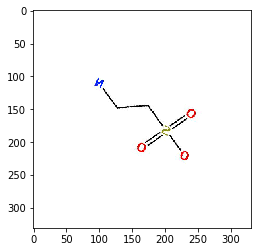

In [4]:
X, y = next(d_cls.train_gen)
print(X.shape)
print(y.shape)
print(X[0].shape)
print(y[0])
%matplotlib inline 
util.show_np_img(X[0])

(6, 331, 331, 3)
(6, 12)
(331, 331, 3)
[ 0.  0.  0. -1.  0.  0.  0.  0.  1.  0.  0.  0.]


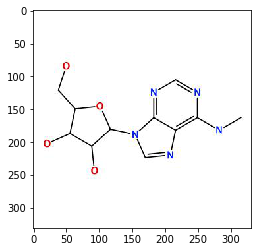

In [5]:
X, y = next(d_cls.valid_gen)
print(X.shape)
print(y.shape)
print(X[0].shape)
print(y[0])
%matplotlib inline  
util.show_np_img(X[0])

## get_train_valid_test.generator_12output() 変更したから確認_20181228
#### 変更前と一致してる

In [6]:
def test_generator_12output(generator):
    """
    12の出力（task）をだすgenerator
    # https://github.com/keras-team/keras/issues/5036
    Args:
        generator:keras.preprocessing.image.ImageDataGenerator
    Returns:
        入力画素(X), 12taskのラベルのリスト([y[:,0], y[:,1], y[:,2]…]) のgenerator
    """
    while True:
        X_y = generator.next()
        X = X_y[0]
        y = X_y[1]
        # 入力画素(X1[0]), 12taskのラベルのリスト([X1[0], X2[1], X3[1]]…)
        print(y.shape)
        y_conv = []
        for i in range(y.shape[1]):
            y_conv.append(y[:,i])
        yield X, generator.__next__(), y_conv, [y[:,0], y[:,1], y[:,2], y[:,3], y[:,4], y[:,5], y[:,6], y[:,7], y[:,8], y[:,9], y[:,10], y[:,11]]

(17, 12)
(17, 331, 331, 3)
(331, 331, 3)
(17, 331, 331, 3)
(331, 331, 3)
y_task0 [ 1. -1. -1.  0.  0.  0. -1.  0.  0. -1. -1.  0.  0.  0.  0.  0.  0.]
y_task1 [ 0.  0.  0.  0.  0.  0. -1.  0.  0. -1. -1.  0.  0.  0.  0.  0.  0.]
y_task2 [ 0. -1.  0.  0.  0.  0. -1.  0. -1. -1. -1.  0.  0.  0.  0.  0.  0.]
y_task3 [ 0.  1. -1.  0.  0.  0. -1.  0.  0. -1. -1. -1.  0.  0.  0.  0.  0.]
y_task4 [-1. -1. -1.  0.  0.  1. -1.  0.  0. -1. -1.  0.  0.  0.  0.  0.  0.]
y_task5 [ 0.  0.  0.  0.  0.  0. -1.  0.  0. -1. -1.  0.  0.  0.  0.  0.  0.]
y_task6 [ 0. -1.  0.  0.  0.  0. -1.  0.  0. -1. -1.  0.  0.  0.  0.  0.  0.]
y_task7 [ 0. -1. -1.  0.  0. -1.  0.  0.  0.  0. -1. -1. -1.  0. -1. -1.  0.]
y_task8 [ 0.  0.  0.  0.  0.  0. -1.  0.  0. -1. -1.  0.  0.  0.  0.  0.  0.]
y_task9 [ 0. -1. -1.  0.  0. -1.  0.  0.  0.  0.  0.  0. -1.  0. -1. -1.  0.]
y_task10 [ 0.  1.  0.  0.  0.  0. -1. -1.  0. -1. -1. -1.  0.  0.  0. -1.  0.]
y_task11 [ 0.  1.  0.  0.  0.  0. -1.  0.  0. -1. -1.  0.  0.  0.  0

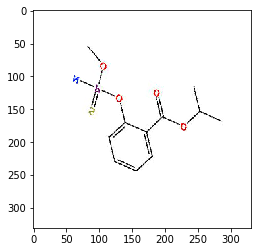

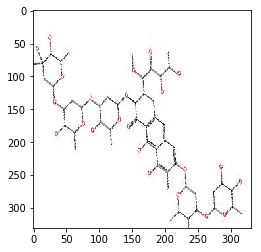

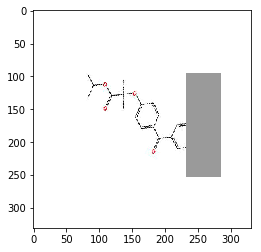

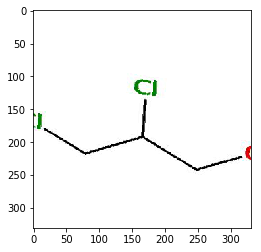

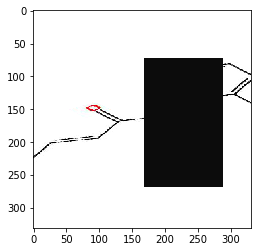

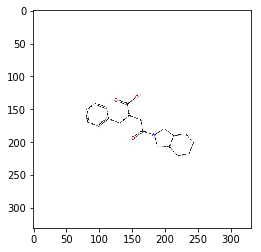

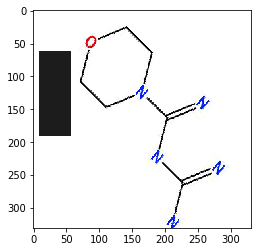

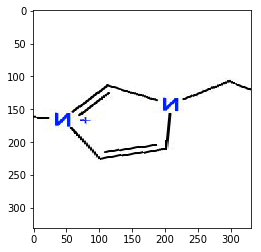

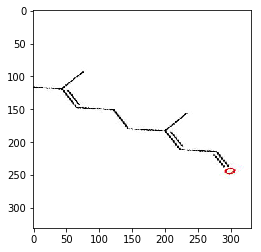

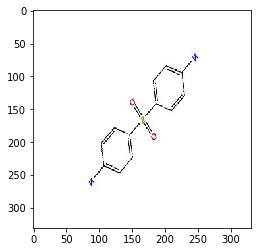

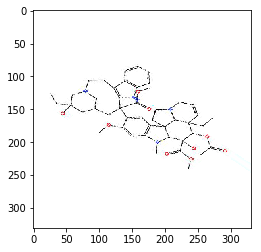

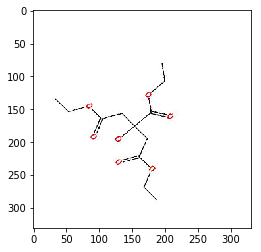

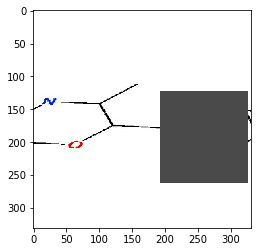

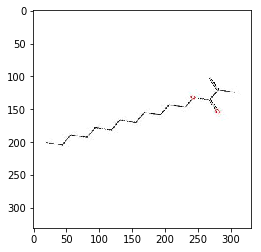

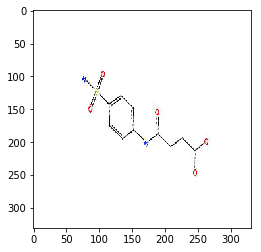

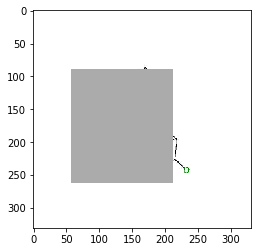

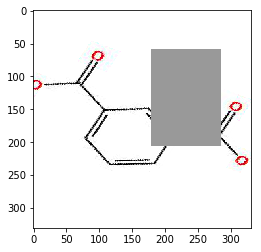

%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%


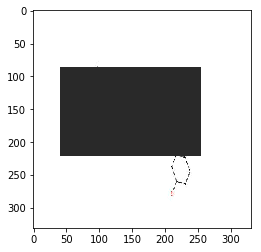

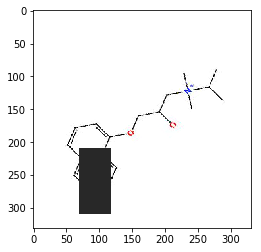

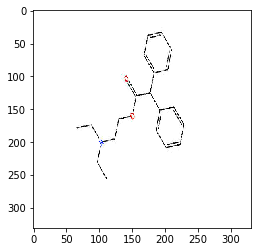

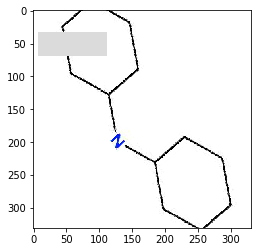

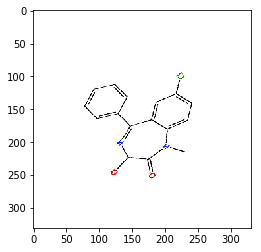

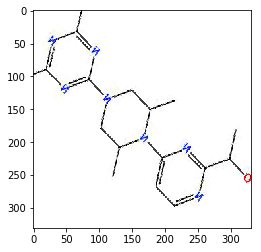

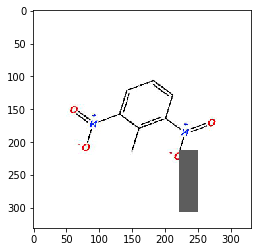

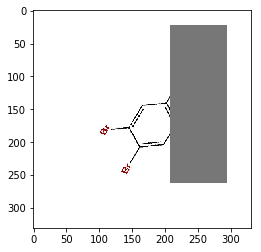

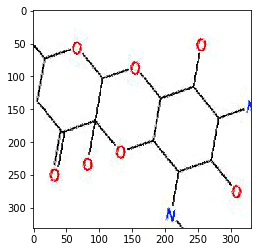

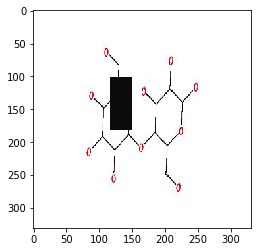

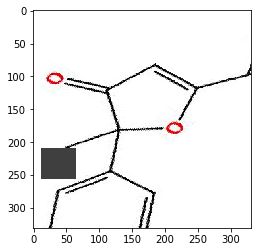

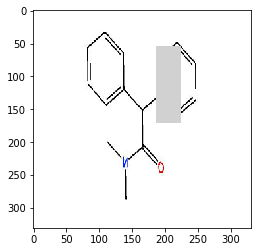

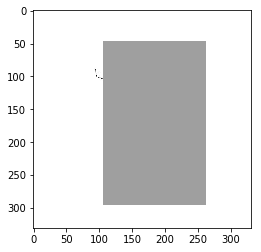

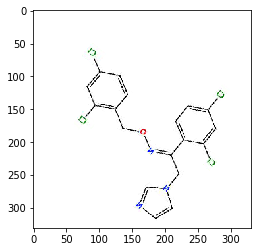

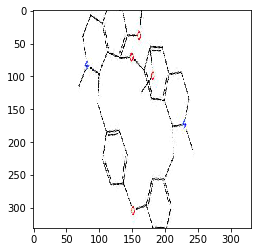

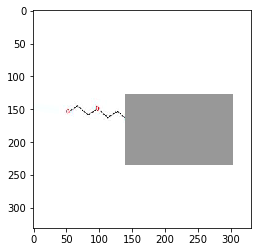

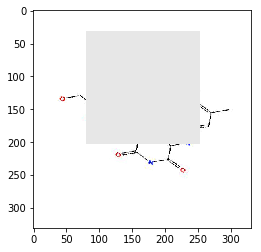

In [10]:
gen12 = test_generator_12output(d_cls.train_gen)

X, X_y_old, y_list, y_list_old = next(gen12)
print(X.shape)
print(X[0].shape)

X_old = X_y_old[0]
y_old = X_y_old[1]
print(X_old.shape)
print(X_old[0].shape)

%matplotlib inline 
for i,y in enumerate(y_list):
    print('y_task'+str(i), y)
print('--------------------')
for i,y in enumerate(y_list_old):
    print('y_task'+str(i), y)
    
# 一致判定
flag =  np.allclose(y_list, y_list_old)
print('#####')
print(flag)
print('#####')
    
for i in range(X.shape[0]):
    util.show_np_img(X[i])
print('%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%%')
for i in range(X_old.shape[0]):
    util.show_np_img(X_old[i])

## get_train_valid_test.generator_12output
- ニューラルネットワークを分岐させてMulti-task learningのときに使うもの

(17, 331, 331, 3)
(331, 331, 3)
y_task0 [ 0. -1.  0.  1.  0. -1.  0.  0.  0. -1.  0.  0.  0. -1.  0.  0.  1.]
y_task1 [ 1. -1.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0.  0. -1.  0.  0.  0.]
y_task2 [ 0. -1.  0.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0. -1.  0.  0.  0.]
y_task3 [-1. -1.  0.  0. -1.  1.  0. -1.  0. -1.  0.  0. -1. -1.  0.  0.  0.]
y_task4 [ 1. -1.  0.  1. -1. -1.  0.  0.  0.  0.  0.  0.  0. -1.  0.  0.  0.]
y_task5 [-1. -1.  0.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0. -1.  0.  0.  0.]
y_task6 [ 0. -1.  0.  0. -1. -1.  0.  0.  0. -1.  0.  0. -1. -1.  0.  0.  0.]
y_task7 [-1.  0.  1.  0. -1.  1.  0.  0.  0. -1.  0.  0. -1. -1. -1.  0.  0.]
y_task8 [ 0. -1.  0.  0.  0. -1.  0.  0.  0.  0.  0.  0.  0. -1.  0.  0.  0.]
y_task9 [-1.  0. -1.  0.  0. -1.  0.  0.  0. -1.  0.  0. -1.  0. -1.  0.  0.]
y_task10 [ 0. -1.  0. -1.  0. -1.  0.  0.  0. -1.  0.  0. -1. -1.  0.  0.  0.]
y_task11 [ 0. -1.  0.  0.  0. -1.  0.  0.  0. -1.  0.  0.  0. -1.  0.  0.  0.]


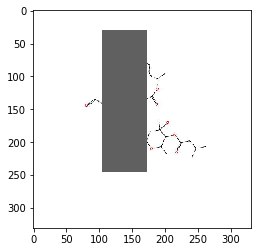

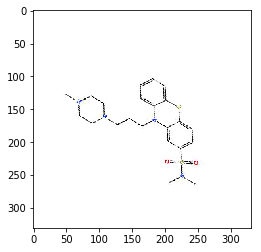

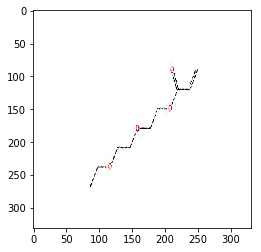

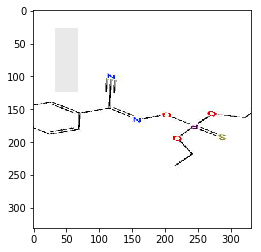

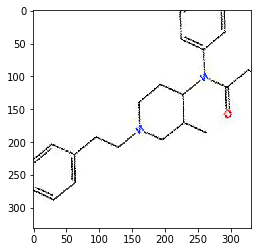

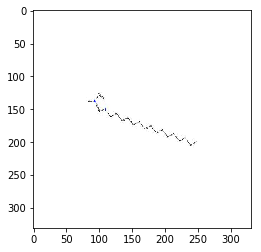

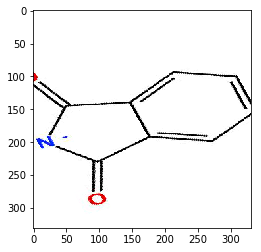

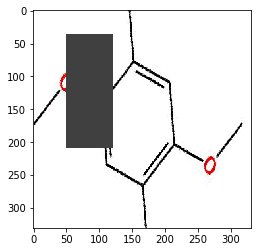

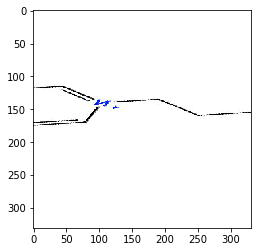

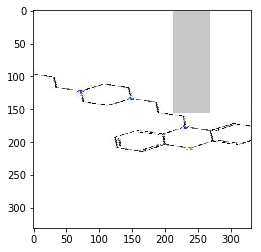

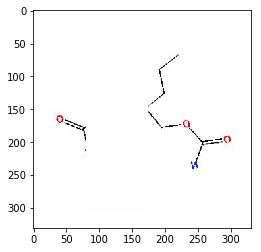

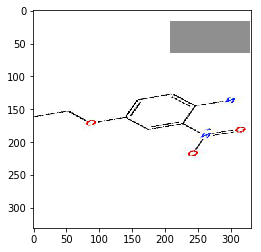

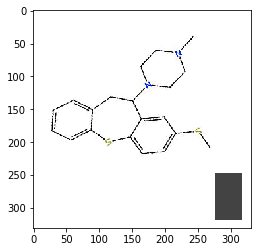

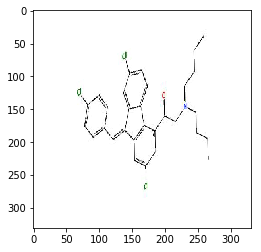

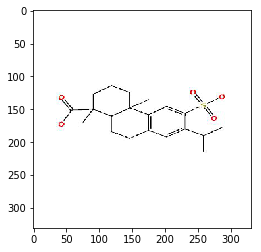

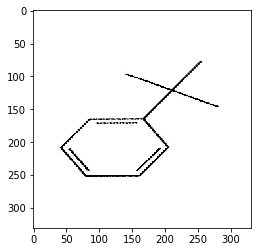

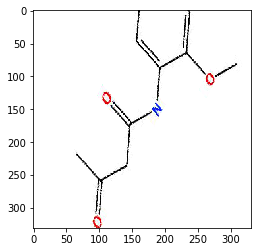

In [8]:
gen12 = get_train_valid_test.generator_12output(d_cls.train_gen)

X, y_list = next(gen12)
print(X.shape)
print(X[0].shape)
%matplotlib inline 
for i,y in enumerate(y_list):
    print('y_task'+str(i), y)

for i in range(X.shape[0]):
    util.show_np_img(X[i])

(6, 331, 331, 3)
(331, 331, 3)
y_task0 [ 0.  0.  0. -1.  0.  0.]
y_task1 [0. 0. 0. 0. 0. 0.]
y_task2 [0. 0. 0. 0. 0. 0.]
y_task3 [-1.  0.  0. -1.  0.  0.]
y_task4 [ 0.  0.  0. -1.  0.  0.]
y_task5 [0. 0. 0. 0. 0. 0.]
y_task6 [ 0.  0.  0. -1.  0.  0.]
y_task7 [0. 0. 0. 1. 0. 0.]
y_task8 [0. 0. 0. 0. 0. 0.]
y_task9 [0. 0. 0. 1. 0. 0.]
y_task10 [ 0.  0.  0.  1.  0. -1.]
y_task11 [0. 0. 0. 1. 0. 0.]


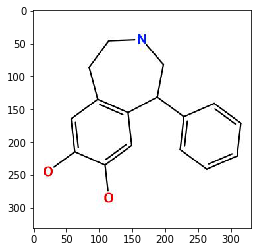

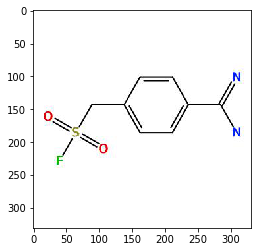

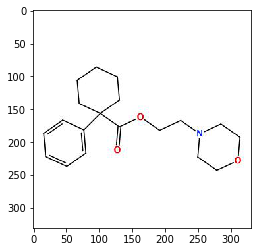

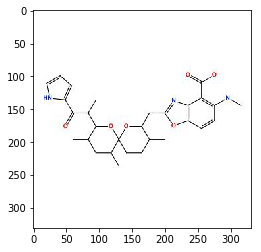

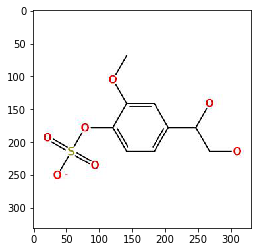

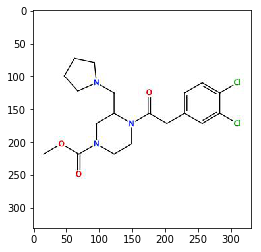

In [9]:
gen12 = get_train_valid_test.generator_12output(d_cls.valid_gen)

X, y_list = next(gen12)
print(X.shape)
print(X[0].shape)
%matplotlib inline 
for i,y in enumerate(y_list):
    print('y_task'+str(i), y)

for i in range(X.shape[0]):
    util.show_np_img(X[i])